# **Cell nuclei detection by Stardist 2D**
---

**Stardist** is deep-learning method that can be used to segment cell nuclei in 2D (xy) single images or in stacks (xyz). 

*Disclaimer*:

This notebook is part of the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories.

This notebook is largely based on the paper:

[Cell Detection with Star-convex Polygons](https://arxiv.org/abs/1806.03535)

Uwe Schmidt, Martin Weigert, Coleman Broaddus, and Gene Myers.
International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI), Granada, Spain, September 2018.

[Star-convex Polyhedra for 3D Object Detection and Segmentation in Microscopy](https://arxiv.org/abs/1908.03636)

Martin Weigert, Uwe Schmidt, Robert Haase, Ko Sugawara, and Gene Myers. arXiv, 2019

**The Original code** is freely available in GitHub:
https://github.com/mpicbg-csbd/stardist

**Please also cite this original paper when using or developing this notebook.**


# **How to use this notebook?**

---
###**Structure of a notebook**

A notebook is conveniently made of text annotation that describe the code and workflow (**Text cells**) as well as sections that contain the code that is executed (**Code cells**).  

**Text cells** provide information and can be modified by douple-clicking the cell. You are currently reading the text cell. You can create a new text by clicking `+ Text`.

**Code cells** contain code and the code can be modfied by selecting the cell. To execute the cell, move your cursor on the `[ ]`-mark on the left side of the cell (play button appears). Click to execute the cell. After execution is done the animation of play button stops. You can create a new coding cell by clicking `+ Code`.

---
###**Table of contents, Code snippets** and **Files**

On the top left side of the notebook you find three tabs which contain from top to bottom the table of contents, code snippets and files.

*Table of contents* = contains structure of the notebook. Click the content to move quickly between sections.

*Code snippets* = contain examples how to code certain tasks. You can ignore this when using this notebook.

*Files* = contain all available files. After mounting your google drive (see section 1.) you will find your files and folders here. 

**Remember that all uploaded files are purged after changing the runtime.** All files saved in Google Drive will remain. You do not need to use the Mount Drive-button; your Google Drive is connected in section 1.2.

**Note:** The "sample data" in "Files" contains default files. Do not upload anything in here!

---
###**Making changes to the notebook**

**You can make a copy** of the notebook and save it to your Google Drive. To do this click file -> save a copy in drive.

To **edit a cell**, double click on the text. This will show you either the source code (in code cells) or the source text (in text cells).
You can use the `#`-mark in code cells to comment out parts of the code. This allows you to keep the original code piece in the cell as a comment.

#**0. Before getting started**
---
<font size = 4>

Before you run the notebook, please ensure that you are logged into your Google account and have the training and/or data to process in your Google Drive.

**Important Notes**
For Stardist to train, it needs to have access to a paired training dataset corresponding of images of nuclei and corresponding masks. Information on how to generate a training dataset is available in our Wiki page: https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki


The data structure is important. It is necessary that all the input data are in the same folder and that all the output data is in a separate folder. The provided training dataset is already split in two folders called "Training - Images" (Training_source) and "Training - Masks" (Training_target).

Additionally, the corresponding Training_source and Training_target files need to have **the same name**.

Please note that you currently can **only use .tif files!**

You can also provide a folder that contains the data that you wish to analyse with the trained network once all training has been performed. This can include Test dataset for which you have the equivalent output and can compare to what the network provides.

Here's a common data structure that can work:
*   Experiment A
    - train
      - images of nuclei (Training_source)
        - img_1.tif, img_2.tif, ...
      - Masks (Training_target)
        - img_2.tif, img_2.tif, ...
    - Test dataset 
    - results


---

# **1. Set the Runtime type and mount your Google Drive**

---






### **1.1 Change the Runtime**

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelator: GPU** *(Graphics processing unit (GPU)*


In [0]:
#@title Run this cell to check if you have GPU access
%tensorflow_version 1.x

import tensorflow as tf
if tf.test.gpu_device_name()=='':
  print('You do not have GPU access.') 
  print('Did you change your runtime ?') 
  print('If the runtime setting is correct then Google did not allocate a GPU for your session')
  print('Expect slow performance. To access GPU try reconnecting later')

else:
  print('You have GPU access')

You have GPU access


### **1.2. Mount Google Drive**
<font size = 4> To use this notebook on the provided data, you need to mount your Google Drive to this notebook.

<font size = 4> Play the cell below to mount your Google Drive and follow the link. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will allow Colab to have access to teh data on the drive. 

<font size = 4> Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [0]:
#@markdown ###Play the cell to Mount your Google Drive.

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# **2. Install Stardist and Dependencies**
---


In [0]:
#@markdown ###Install Stardist and dependencies

%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
print("Tensorflow enabled.")

# Install packages which are not included in Google Colab

!pip install tifffile # contains tools to operate tiff-files
!pip install csbdeep  # contains tools for restoration of fluorescence microcopy images (Content-aware Image Restoration, CARE). It uses Keras and Tensorflow.
!pip install stardist # contains tools to operate STARDIST.

# Import libraries needed to perform notebook
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
from pathlib import Path
import os
import numpy as np # collection of matematical operations
import matplotlib.pyplot as plt # tools for creating figures and plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from glob import glob # program can read path names 
from tqdm import tqdm # imports tools to create progress meter
from tifffile import imread # program can open and read tiff-files
from csbdeep.utils import Path, normalize, download_and_extract_zip_file, plot_history # for loss plot
from csbdeep.io import save_tiff_imagej_compatible

# import stardist
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available, relabel_image_stardist, random_label_cmap,  relabel_image_stardist, _draw_polygons, export_imagej_rois
from stardist.models import Config2D, StarDist2D, StarDistData2D # import objects
from stardist.matching import matching_dataset
np.random.seed(42)
lbl_cmap = random_label_cmap()



1.15.0
Tensorflow enabled.
     |████████████████████████████████| 133kB 6.4MB/s 
     |████████████████████████████████| 18.1MB 188kB/s 
     |████████████████████████████████| 71kB 5.4MB/s 
     |████████████████████████████████| 399kB 8.2MB/s 
  Created wheel for stardist: filename=stardist-0.4.1-cp36-cp36m-linux_x86_64.whl size=1845497 sha256=fdcd227a3b7a05dcff1cec5c5e6c6ff8b512f493b5b3a2bdaa0fa32523d9b6c6
  Stored in directory: /root/.cache/pip/wheels/46/be/f5/1f4594371043e621355a621ac6d825d61c6837ce550f35a104
Successfully built stardist


Using TensorFlow backend.


# **3. Select your parameters and paths**

---

The code below allows the user to enter the paths to where the training data is and to define the training parameters.


<font size = 5> **Paths for training, predictions and results**

<font size = 4>**`Training_source:`, `Training_target`:** These are the paths to your folders containing the Training_source (images of nuclei) and Training_target (masks) training data respecively. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`model_name`:** Use only my_model -style, not my-model. 

<font size = 4>**`model_path`**: Enter the path where your model will be saved once trained (for instance your result folder).


<font size = 5>**Training Parameters**

<font size = 4>**`number_of_steps`:** Good network training may require at least 300 steps but will take a while. **Default value: 100**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) network will be trained. A larger number of epochs may improve performance but risks overfitting to the training data. Start with 30-100 and test the performance after training (see 4.8.). **Default value: 30**

<font size = 4>**`n_rays`:** Set number of rays (corners) used for Stardist (for instance square has 4 corners). **Default value: 32** 

In [0]:
#@markdown ###Path to training images: 
Training_source = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Stardist/Training - Images" #@param {type:"string"}
training_images = Training_source


Training_target = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Stardist/Training - Masks" #@param {type:"string"}
mask_images = Training_target 


#@markdown ###Name of the model and path to model folder:
model_name = "high3" #@param {type:"string"}

model_path = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Stardist/results" #@param {type:"string"}
trained_model = model_path 

#@markdown ### Other parameters for training:
number_of_epochs = 50 #@param {type:"number"}
input_epochs = number_of_epochs
number_of_steps = 100 #@param {type:"number"}
input_steps = number_of_steps

n_rays = 32 #@param {type:"number"}

# Here we add "/*.tif" script to the end of the path
# -> funtion "glob" (in 5.3) regonzises all tiff-files
# in that folder

# training
training_images=training_images+"/*.tif"
mask_images=mask_images+"/*.tif"







#**4. Train your network**

### **4.1. Prepare the training data and model for training**
<font size = 4>Here, we use the information from 3. to build the model and convert the training data into a suitable format for training.

In [0]:
#@markdown ###Create the model and dataset objects

# this funtion imports training images and masks and sorts them suitable for the network
X = sorted(glob(training_images))   
Y = sorted(glob(mask_images))   

# assert -funtion check that X and Y really have images. If not this cell raises an error
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
!cat /proc/meminfo | grep 'MemAvailable'

# Here we map the training dataset (images and masks).

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

#Normalize images and fill small label holes.
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

#Here we split the your training dataset into training images (90 %) and validation images (10 %). 
#It is advisable to use 10 % of your training dataset for validation. This ensures the truthfull validation error value. If only few validation images are used network may choose too easy or too challenging images for validation. 
# split training data (images and masks) into training images and validation images.
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = use_gpu,
    n_channel_in = n_channel,
)

#here we limit GPU to 80%
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)


# Here we create a model according to section 5.3.
model = StarDist2D(conf, name=model_name, basedir=trained_model)
!cat /proc/meminfo | grep 'MemAvailable'

#Here we check the FOV of the network.
median_size = calculate_extents(list(Y), np.median)
fov = np.array(model._axes_tile_overlap('YX'))
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")



MemAvailable:   12172768 kB


100%|██████████| 28/28 [00:00<00:00, 33.56it/s]

number of images:  28
- training:        24
- validation:       4







Using default values: prob_thresh=0.5, nms_thresh=0.4.
MemAvailable:   12108728 kB








### **4.2. Inspecting training data**

<font size = 4>Here, we show one of the image and associated masks that will be used for training the network.
---



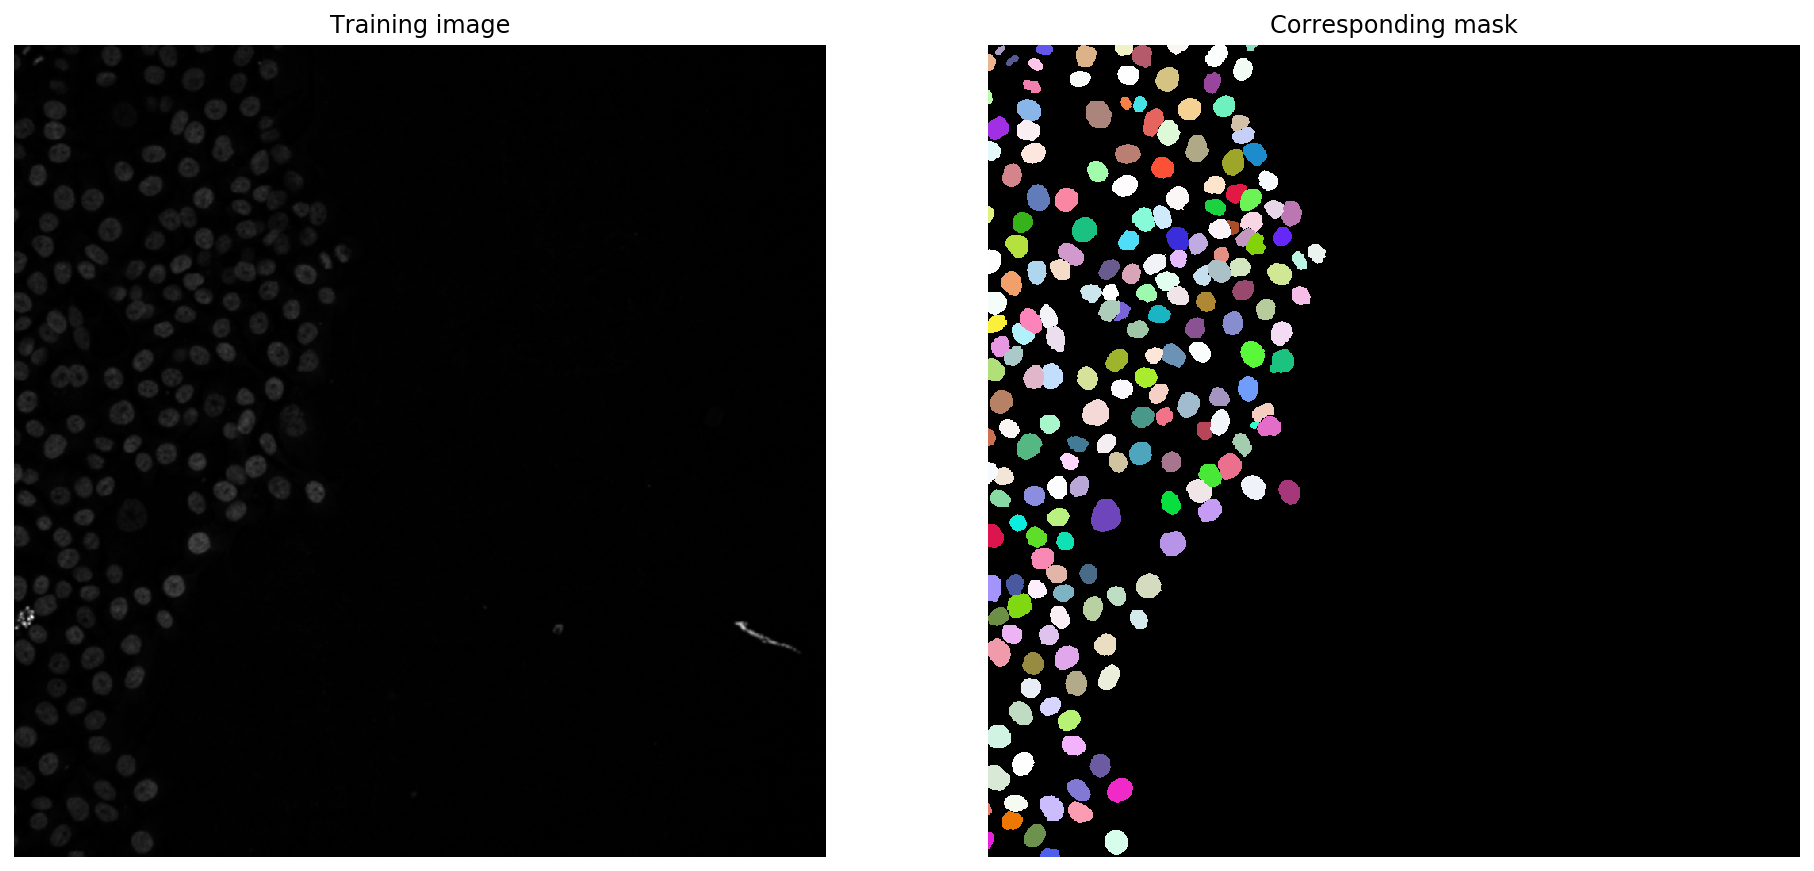

In [0]:
#@markdown ###Play the cell to show the images.
i = min(9, len(X)-1)
img, lbl = X[i], Y[i]
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Training image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('Corresponding mask')
None;

### **4.3. Train the network**
<font size = 4>When playing the cell below you should see updates after each epoch (round). Network training can take some time.

<font size = 4>* **CRITICAL NOTE:** Google Colab has a time limit for processing (to prevent using GPU power for datamining). Training time must be less than 12 hours! If training takes longer than 12 hours, please decrease the number of epochs or number of patches. Another way circumvent this is to save the parameters of the model after training and start training again from this point.

In [0]:
#@markdown ###Start Training
augmenter = None

# def augmenter(X_batch, Y_batch):
#     """Augmentation for data batch.
#     X_batch is a list of input images (length at most batch_size)
#     Y_batch is the corresponding list of ground-truth label images
#     """
#     # ...
#     return X_batch, Y_batch

# Training the model. 
# 'input_epochs' and 'steps' refers to your input data in section 5.1 
history = model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                      epochs=input_epochs, steps_per_epoch=input_steps)
None;



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Epoch 1/50
100/100 [==============================] - 22s 221ms/step - loss: 1.7887 - prob_loss: 0.3370 - dist_loss: 7.2584 - prob_kld: 0.2424 - dist_relevant_mae: 7.2577 - dist_relevant_mse: 85.2138 - val_loss: 1.2637 - val_prob_loss: 0.2610 - val_dist_loss: 5.0135 - val_prob_kld: 0.1621 - val_dist_relevant_mae: 5.0125 - val_dist_relevant_mse: 40.9854

Epoch 2/50
100/100 [==============================] - 19s 187ms/step - loss: 1.1811 - prob_loss: 0.2081 - dist_loss: 4.8648 - prob_kld: 0.1170 - dist_relevant_mae: 4.8636 - dist_r

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.110341). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 19s 193ms/step - loss: 0.4366 - prob_loss: 0.1153 - dist_loss: 1.6067 - prob_kld: 0.0229 - dist_relevant_mae: 1.6056 - dist_relevant_mse: 6.8562 - val_loss: 0.3774 - val_prob_loss: 0.1089 - val_dist_loss: 1.3424 - val_prob_kld: 0.0101 - val_dist_relevant_mae: 1.3414 - val_dist_relevant_mse: 3.9011
Epoch 17/50
100/100 [==============================] - 18s 180ms/step - loss: 0.4118 - prob_loss: 0.1116 - dist_loss: 1.5009 - prob_kld: 0.0214 - dist_relevant_mae: 1.4999 - dist_relevant_mse: 6.3151 - val_loss: 0.3553 - val_prob_loss: 0.1079 - val_dist_loss: 1.2371 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.2360 - val_dist_relevant_mse: 3.6547
Epoch 18/50
100/100 [==============================] - 18s 185ms/step - loss: 0.4263 - prob_loss: 0.1152 - dist_loss: 1.5558 - prob_kld: 0.0237 - dist_relevant_mae: 1.5548 - dist_relevant_mse: 6.8771 - val_loss: 0.3591 - val_prob_loss: 0.1098 - val_dist_loss: 1.2467 - val_prob_kld: 0.0110 - val_dist_rel

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.160045). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 18s 183ms/step - loss: 0.3994 - prob_loss: 0.1100 - dist_loss: 1.4470 - prob_kld: 0.0197 - dist_relevant_mae: 1.4459 - dist_relevant_mse: 6.0265 - val_loss: 0.3552 - val_prob_loss: 0.1116 - val_dist_loss: 1.2177 - val_prob_kld: 0.0128 - val_dist_relevant_mae: 1.2166 - val_dist_relevant_mse: 3.5937
Epoch 23/50
100/100 [==============================] - 18s 181ms/step - loss: 0.3894 - prob_loss: 0.1091 - dist_loss: 1.4015 - prob_kld: 0.0199 - dist_relevant_mae: 1.4004 - dist_relevant_mse: 5.5951 - val_loss: 0.3496 - val_prob_loss: 0.1077 - val_dist_loss: 1.2094 - val_prob_kld: 0.0089 - val_dist_relevant_mae: 1.2083 - val_dist_relevant_mse: 3.1911
Epoch 24/50
100/100 [==============================] - 18s 180ms/step - loss: 0.4262 - prob_loss: 0.1116 - dist_loss: 1.5730 - prob_kld: 0.0241 - dist_relevant_mae: 1.5719 - dist_relevant_mse: 7.3006 - val_loss: 0.3331 - val_prob_loss: 0.1082 - val_dist_loss: 1.1243 - val_prob_kld: 0.0094 - val_dist_rel

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.104173). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 19s 191ms/step - loss: 0.3705 - prob_loss: 0.1152 - dist_loss: 1.2766 - prob_kld: 0.0196 - dist_relevant_mae: 1.2758 - dist_relevant_mse: 5.0063 - val_loss: 0.3142 - val_prob_loss: 0.1074 - val_dist_loss: 1.0341 - val_prob_kld: 0.0085 - val_dist_relevant_mae: 1.0332 - val_dist_relevant_mse: 2.5248
Epoch 37/50
100/100 [==============================] - 19s 194ms/step - loss: 0.3700 - prob_loss: 0.1175 - dist_loss: 1.2625 - prob_kld: 0.0193 - dist_relevant_mae: 1.2617 - dist_relevant_mse: 4.8904 - val_loss: 0.3154 - val_prob_loss: 0.1074 - val_dist_loss: 1.0401 - val_prob_kld: 0.0086 - val_dist_relevant_mae: 1.0392 - val_dist_relevant_mse: 2.4800
Epoch 38/50
100/100 [==============================] - 18s 181ms/step - loss: 0.3442 - prob_loss: 0.1066 - dist_loss: 1.1880 - prob_kld: 0.0171 - dist_relevant_mae: 1.1871 - dist_relevant_mse: 4.2927 - val_loss: 0.3001 - val_prob_loss: 0.1087 - val_dist_loss: 0.9568 - val_prob_kld: 0.0099 - val_dist_rel

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.107838). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


  6/100 [>.............................] - ETA: 16s - loss: 0.3682 - prob_loss: 0.1238 - dist_loss: 1.2221 - prob_kld: 0.0219 - dist_relevant_mae: 1.2214 - dist_relevant_mse: 4.9070

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.102602). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 18s 184ms/step - loss: 0.3419 - prob_loss: 0.1090 - dist_loss: 1.1645 - prob_kld: 0.0166 - dist_relevant_mae: 1.1637 - dist_relevant_mse: 4.2549 - val_loss: 0.3075 - val_prob_loss: 0.1106 - val_dist_loss: 0.9846 - val_prob_kld: 0.0118 - val_dist_relevant_mae: 0.9839 - val_dist_relevant_mse: 2.3131
Epoch 47/50
100/100 [==============================] - 18s 177ms/step - loss: 0.3473 - prob_loss: 0.1071 - dist_loss: 1.2012 - prob_kld: 0.0171 - dist_relevant_mae: 1.2004 - dist_relevant_mse: 4.6097 - val_loss: 0.2972 - val_prob_loss: 0.1089 - val_dist_loss: 0.9414 - val_prob_kld: 0.0101 - val_dist_relevant_mae: 0.9407 - val_dist_relevant_mse: 2.1304
Epoch 48/50
100/100 [==============================] - 18s 179ms/step - loss: 0.3345 - prob_loss: 0.1071 - dist_loss: 1.1371 - prob_kld: 0.0165 - dist_relevant_mae: 1.1364 - dist_relevant_mse: 4.0402 - val_loss: 0.3204 - val_prob_loss: 0.1102 - val_dist_loss: 1.0511 - val_prob_kld: 0.0113 - val_dist_rel

### **4.4. Evaluate the training**



<font size = 4>It is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

<font size = 4>**Loss** <code>(loss)</code> describes an error value after each epoch for the difference between the model's prediction and its 'GT' target.

<font size = 4>**Validation error** <code>(val_loss)</code> describes the same error value between the model's prediction on a validation image (taken from 'low') and compared to it's target (from 'GT').

<font size = 4>During training both values should decrease before reaching a minimal value which does not decrease even after further training. Comparing the development of the validation error with the training error can give insights into the model's performance.

<font size = 4>If **validation error is clearly higher than training error**, it means that the training data might be too complex or diverse. In this case, the trained network fails to improve unseen images. To avoid this, increase the number of epochs and check if you can improve your dataset with more examples.

<font size = 4>If **validation error is clearly smaller than training error**, it means that training data is too simple which allows the network to learn the training data perfectly but to perform poorly on unseen data. This is called overfitting which should be always be avoided as it can lead to artefacts in the predctions of the network. First steps to avoid this can be to reduce the number of training epochs or to use a larger training dataset.

['dist_loss', 'dist_relevant_mae', 'dist_relevant_mse', 'loss', 'lr', 'prob_kld', 'prob_loss', 'val_dist_loss', 'val_dist_relevant_mae', 'val_dist_relevant_mse', 'val_loss', 'val_prob_kld', 'val_prob_loss']


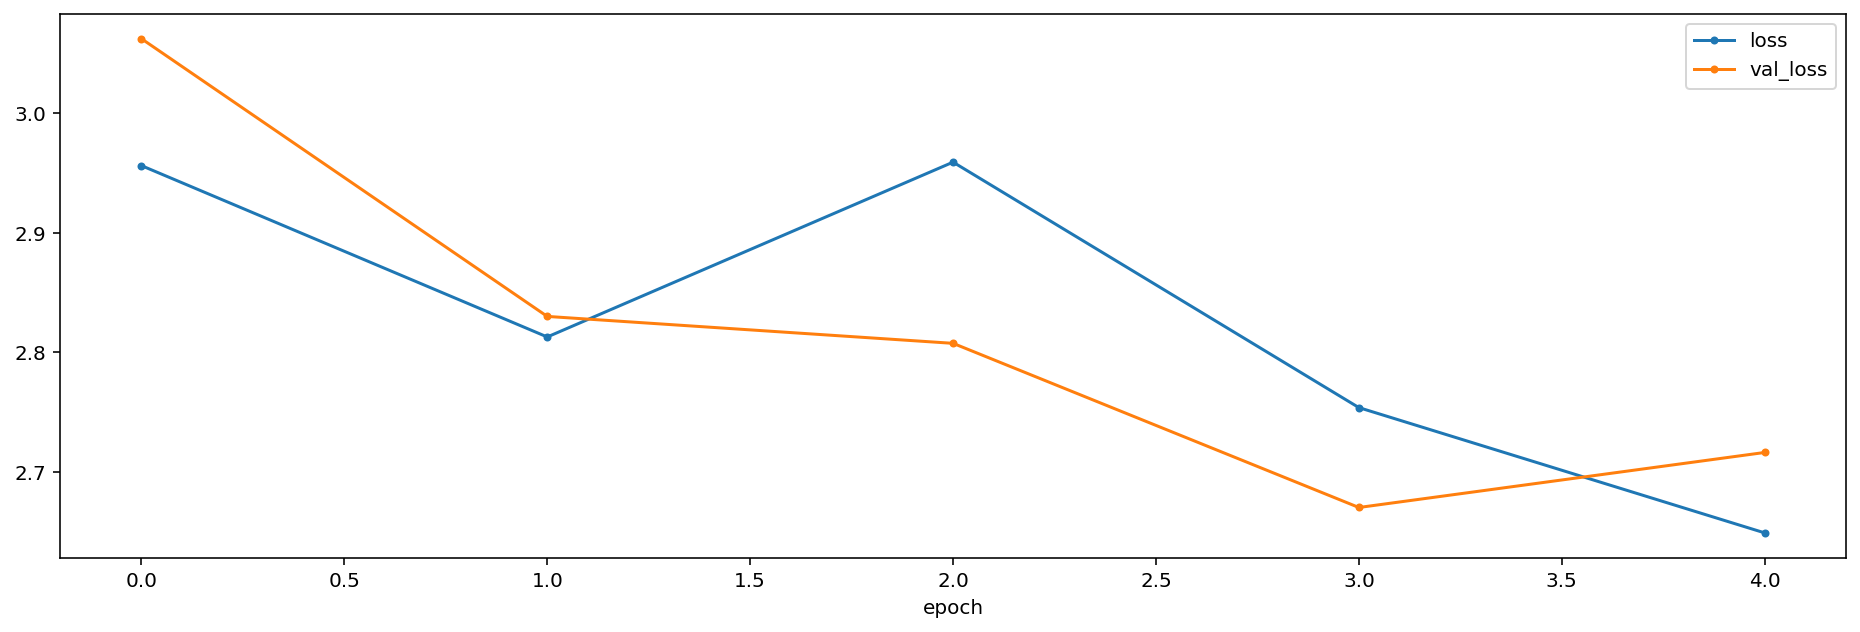

In [0]:
#@markdown ###Play the cell to show a figure of the training errors


import pandas as pd
import csv

# Sorts the results and prints headlines
print(sorted(list(history.history.keys())))

# Create figure framesize
errorfigure = plt.figure(figsize=(16,5))

# Choose the values you wish to compare. 
# For example, If you wish to see another values, just replace 'loss' to 'dist_loss'
plot_history(history,['loss','val_loss']); 

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# The figure is saved into content/ as training evaluation.csv (refresh the Files if needed). 
RESULTS = model_path+'/training evaluation.csv'
with open(RESULTS, 'w') as f:
    for key in hist_df.keys():
        f.write("%s,%s\n"%(key,hist_df[key]))




**4.5 Network optimization**
---
Here we optimize your network

In [0]:
#@markdown Play the cell to optimize the network.
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:11<00:03,  1.07it/s, 0.233 -> 0.000]


Using optimized values: prob_thresh=0.234136, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'nms': 0.3, 'prob': 0.23413620812273106}

# **5. Use the network to predict images**

---

<font size = 4>In this section the unseen data (single images or stacks) are processed using the trained model (in section 4). First we upload your unseen images and prepare them for prediction. After that we activate your trained model from section 4 and finally we save results into your Google Drive.

## **5.1. Generate prediction from test dataset**

<font size = 4>The current trained model (from section 4.3) can now be used to process images. If an older model needs to be used, please untick the **Use_the_current_trained_model** box and enter the name and path of the model to use. Predicted output images are saved in your **Prediction_folder** folder as restored image stacks (ImageJ-compatible TIFF images).

<font size = 4>**`Test_data_folder`:** This folder should contains the images that you want to predict using the network that you will train.

<font size = 4>**`Result_folder`:** This folder will contain the predicted output ROI.

<font size = 4>**`Data_type`:** Please indicate if the images you want to predict are single images or stacks



Single images are now beeing predicted
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.520942, nms_thresh=0.4.
One example image is displayed bellow:


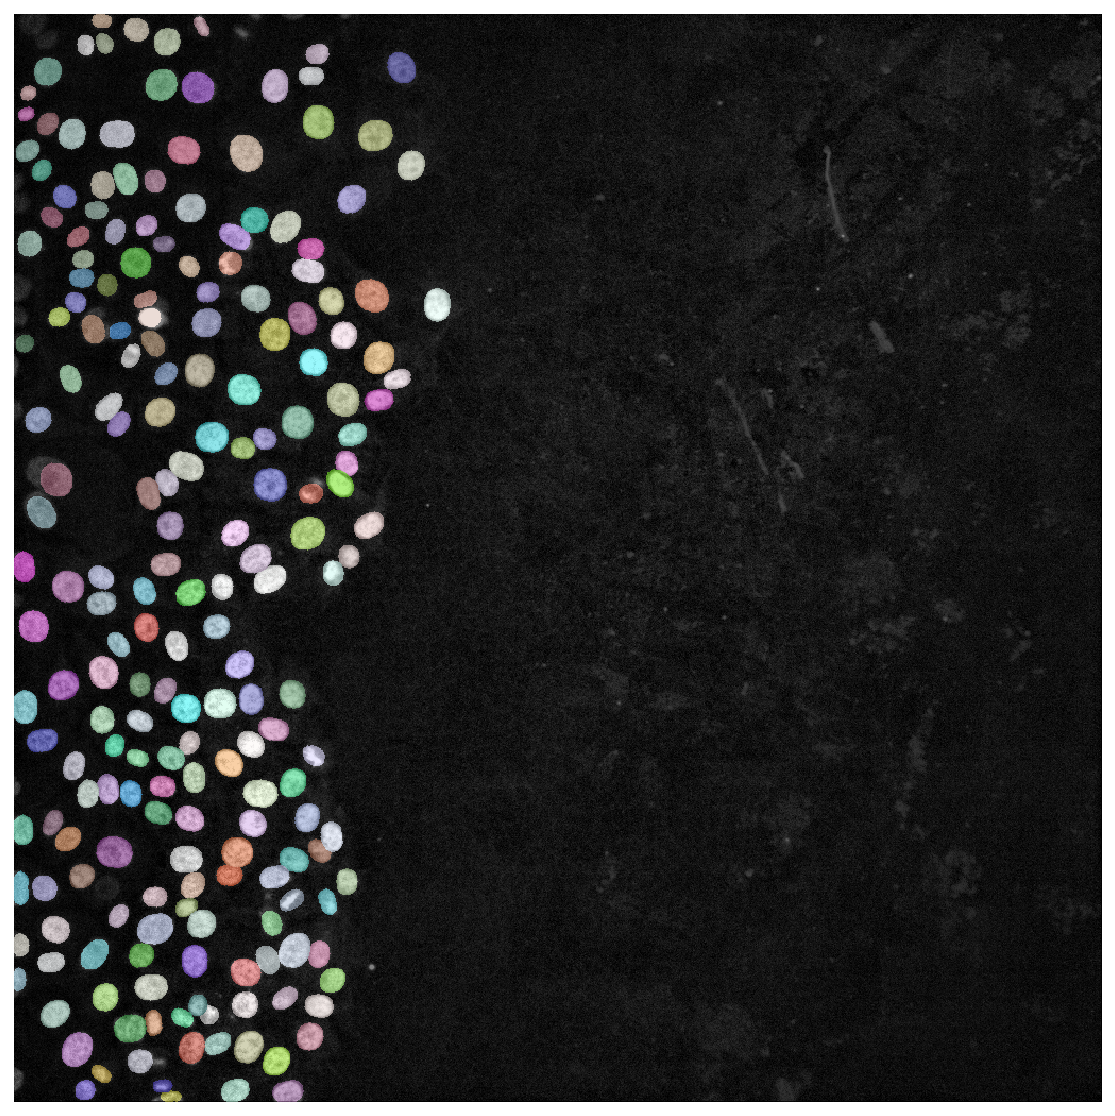

In [0]:
Single_Images = 1
Stacks = 2

#@markdown ### Provide the path to your dataset and to the folder where the prediction will be saved (Result folder), then play the cell to predict output on your unseen images.

Test_data_folder = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Stardist/Test - Images" #@param {type:"string"}
test_dataset = Test_data_folder
#test_batch = "/content/drive/Shared drives/Jacquemet Lab/Lab Projects/Zero Cost AI/Dataset/Nuclei pictures Others" #@param {type:"string"}

results_folder = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Stardist/results" #@param {type:"string"}
results = results_folder

#@markdown ###Are your data single images or stacks?

Data_type = Single_Images #@param ["Single_Images", "Stacks"] {type:"raw"}

# model name and path
#@markdown ###Do you want to use the current trained model?
Use_the_current_trained_model = False #@param {type:"boolean"}


#@markdown ###If not, please provide the name of the model and path to model folder:
inference_model_name = "low" #@param {type:"string"}
inference_model_path = "/content/gdrive/My Drive/Work/manuscript/Ongoing Projects/Zero-Cost Deep-Learning to Enhance Microscopy/test folder/Training datasets/Stardist/results" #@param {type:"string"}

if (Use_the_current_trained_model): 
  print("Using current trained network")
  inference_model_name = model_name
  inference_model_path = model_path

#single images
testDATA = test_dataset
test_dataset=test_dataset+"/*.tif"


if Data_type == 1 :
  print("Single images are now beeing predicted")
  np.random.seed(16)
  lbl_cmap = random_label_cmap()
  X = sorted(glob(test_dataset))
  X = list(map(imread,X))
  n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
  axis_norm = (0,1)   # normalize channels independently
  # axis_norm = (0,1,2) # normalize channels jointly
  if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
  model = StarDist2D(None, name=inference_model_name, basedir=inference_model_path)
  #Sorting and mapping original test dataset
  X = sorted(glob(test_dataset))
  X = list(map(imread,X))
  # modify the names to suitable form: path_images/image_numberX.tif
  FILEnames=[]
  for m in names:
    m=results+'/'+m
    FILEnames.append(m)
  # Save all ROIs into results folder
  lenght_of_X = len(X)
  for i in range(lenght_of_X):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, polygons = model.predict_instances(img)
    export_imagej_rois(FILEnames[i], polygons['coord'])
  print("One example image is displayed bellow:")
  plt.figure(figsize=(10,10))
  plt.imshow(img if img.ndim==2 else img[...,:3], clim=(0,1), cmap='gray')
  plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
  plt.axis('off');

if Data_type == 2 :
  print("Stacks are now beeing predicted")
  np.random.seed(42)
  lbl_cmap = random_label_cmap()
  Y = sorted(glob(test_dataset))
  X = list(map(imread,Y))
  n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
  axis_norm = (0,1)   # normalize channels independently
  # axis_norm = (0,1,2) # normalize channels jointly
  if n_channel > 1:
     print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
  #Load a pretrained network
  model = StarDist2D(None, name=inference_model_name, basedir=inference_model_path)
  # Getting the current work directory (test_batch)
  names = [os.path.basename(f) for f in sorted(glob(test_dataset))]
  thisdir = Path(testDATA)
  outputdir = Path(results)

# Save all ROIs and images in Results folder.
  for num, i in enumerate(X): 
    timelapse = np.stack(i)
    timelapse = normalize(timelapse, 1,99.8, axis=(0,)+tuple(1+np.array(axis_norm)))
    timelapse.shape
    polygons = [model.predict_instances(frame)[1]['coord'] for frame in tqdm(timelapse)]
    save_tiff_imagej_compatible(os.path.join(outputdir, names[num]), timelapse, axes='TYX')
    export_imagej_rois(os.path.join(outputdir, names[num]), polygons)



## **5.2. Store your results**

---
**Copy your folder tree ** and ALL its results elsewhere and after that clean the original folder tree (datasets, results, trained model etc.) if you plan to train or use new networks. Please note that notebook will **OVERWRITE** all files which have the same name.

##**Thank you for using Stardist!**